**Name:** LI XINYAN

**EID:** 55670324

# CS5489 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display    
import seaborn as seb
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import numpy as np
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


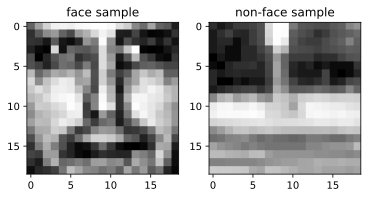

In [3]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

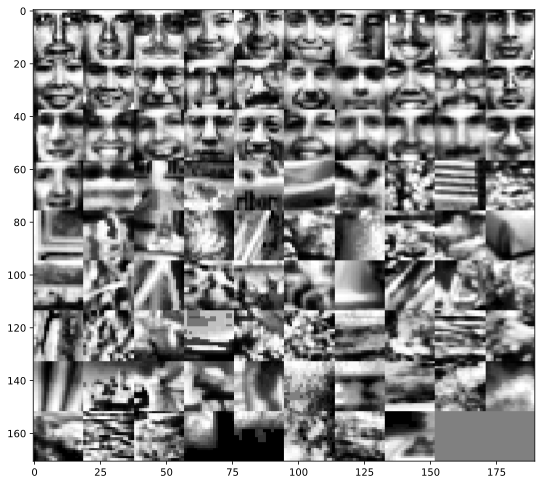

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## 2. Detection using  pixel values

Train an AdaBoost and GradientBoosting classifiers to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

First we will normalize the features.

In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

### AdaBoost

In [7]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    pkeys = list(paramgrid.keys())
    
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

In [8]:
paramgrid = {'learning_rate': np.array([1e-3, 1e-2, 1e-1, 1]),
             'n_estimators': np.array([100, 500, 1000])}

adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=0),
                                     paramgrid, cv=2, n_jobs=-1)
adacv.fit(trainX, trainY)

print("Best params:", adacv.best_params_)

predY = adacv.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("Test accuracy =", acc)

Best params: {'learning_rate': 1.0, 'n_estimators': 1000}
Test accuracy = 0.6260593220338984


(-0.5, 2.5, 3.5, -0.5)

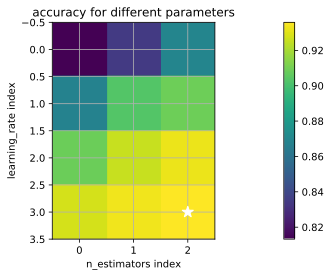

In [9]:
(avgscores, pnames, bestind) = extract_grid_scores(adacv, paramgrid)

paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)

plt.ylabel(pnames[0] + ' index')
plt.xlabel(pnames[1] + ' index')

plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image')

### GradientBoosting

In [11]:
paramgrid = {'learning_rate': np.array([1e-3, 1e-2, 1e-1, 1]),
             'n_estimators': np.array([100, 500, 1000])}

xgbcv = model_selection.GridSearchCV(xgb.XGBClassifier(random_state=0),
                                     paramgrid, cv=2, n_jobs=-1)
xgbcv.fit(trainXn, trainY)

print("best params:", xgbcv.best_params_)

predY = xgbcv.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("Test accuracy =", acc)

best params: {'learning_rate': 0.1, 'n_estimators': 500}
Test accuracy = 0.5


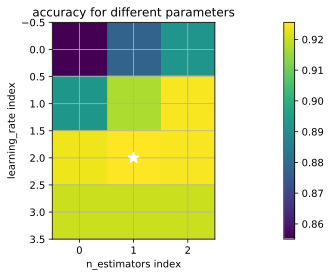

In [12]:
(avgscores, pnames, bestind) = extract_grid_scores(xgbcv, paramgrid)

paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)

plt.ylabel(pnames[0] + ' index')
plt.xlabel(pnames[1] + ' index')

plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image');

### SVM with RBF kernel

In [13]:
def extract_svm_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    pkeys = list(paramgrid.keys())
    
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)
    
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm

    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]
    return avgscores, pkeys, bestind

In [16]:
paramgrid = {'C': np.logspace(-2, 2, 5),
             'gamma': np.logspace(-2, 2, 3)}

svmrbf = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid,
                                      cv=2, n_jobs=-1, verbose=True)
svmrbf.fit(trainX, trainY)

print("best params:", svmrbf.best_params_)

predY = svmrbf.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("Test accuracy =", acc)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
best params: {'C': 10.0, 'gamma': 0.01}
Test accuracy = 0.652542372881356


(-0.5, 2.5, 4.5, -0.5)

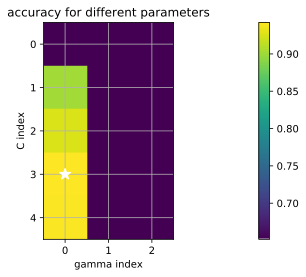

In [17]:
(avgscores, pnames, bestind) = extract_svm_scores(svmrbf, paramgrid)

paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)

plt.ylabel(pnames[0] + ' index')
plt.xlabel(pnames[1] + ' index')

plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image')

### SVM with poly kernel

In [114]:
paramgrid = {'C': np.logspace(-4, 4, 10),
             'degree': np.array([2, 4, 6, 8])}


svmpoly = model_selection.GridSearchCV(svm.SVC(kernel='poly'), paramgrid, 
                                       cv=5, n_jobs=4, verbose=True)
svmpoly.fit(trainX, trainY)

print("best params:", svmpoly.best_params_)

predY = svmpoly.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("Test accuracy =", acc)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best params: {'C': 0.0001, 'degree': 8}
Test accuracy = 0.6663135593220338


(-0.5, 3.5, 9.5, -0.5)

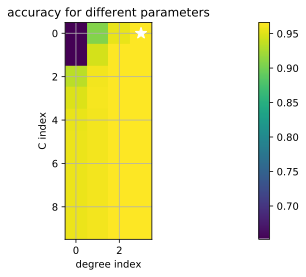

In [22]:
(avgscores, pnames, bestind) = extract_svm_scores(svmpoly, paramgrid)

paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)

plt.ylabel(pnames[0] + ' index')
plt.xlabel(pnames[1] + ' index')

plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image')

### Random Forest Classifier

In [56]:
paramsampler = {'n_estimators':      np.array([10, 50, 100, 200]),
                'max_depth':         np.array([1, 4, 10, 20]),
                'min_samples_split': stats.uniform(0,0.5),
                'min_samples_leaf':  stats.uniform(0,0.5)}

rfrcv = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(random_state=0, class_weight='balanced'),
    param_distributions=paramsampler, random_state=0,
    n_iter=200, cv=5, verbose=1, n_jobs=-1)

rfrcv.fit(trainX, trainY);
print("best params:", rfrcv.best_params_)

predY = rfrcv.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("Test accuracy =", acc)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
best params: {'max_depth': 20, 'min_samples_leaf': 0.027982914174723927, 'min_samples_split': 0.04326624509969401, 'n_estimators': 100}
Test accuracy = 0.725635593220339


### Result Summary

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# AdaBoost
predY = adacv.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("AdaBoost accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("------------------------------------------------------")

# GradientBoosting
predY = xgbcv.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("Grad accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("------------------------------------------------------")

# SVM-RBF
predY = svmrbf.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("SVM-RBF accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("------------------------------------------------------")

# Random Forest
predY = rfrcv.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("Random Forest accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("------------------------------------------------------")

# SVM-Poly
predY = svmpoly.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("SVM-Poly accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))

AdaBoost accuracy = 0.6260593220338984
Classification Report
               precision    recall  f1-score   support

           0       0.57      0.99      0.73       472
           1       0.98      0.26      0.41       472

    accuracy                           0.63       944
   macro avg       0.77      0.63      0.57       944
weighted avg       0.77      0.63      0.57       944

------------------------------------------------------
Grad accuracy = 0.5
Classification Report
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       472
           1       0.00      0.00      0.00       472

    accuracy                           0.50       944
   macro avg       0.25      0.50      0.33       944
weighted avg       0.25      0.50      0.33       944

------------------------------------------------------
SVM-RBF accuracy = 0.652542372881356
Classification Report
               precision    recall  f1-score   support

           0    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Which classifier was best?

According to the above result, the ramdom forest classifier has the highest accuracy = 0.72.

From the classification reports, I noticed that all the five classifiers have high recall scores on label '0' but low precision. This observation suggested that the classifiers can recognize most of the non-human faces but fail to classify the human face correctly (i.e., classify a human face as a non-human face).

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [115]:
# predY: the prediction of the classifier SVM-poly

predY = svmpoly.best_estimator_.predict(testX)

Pind = where(predY==1) # indicies for face predictions
Nind = where(predY==0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP + FN) # Recall
FPR = FP / (FP + TN) # 
Accuracy = (TP + TN) / (TP + FP + FN + TN)

print("TP = ", TP)
print("FP = ", FP)
print("TN = ", TN)
print("FN = ", FN)
print("TPR = ", TPR)
print("FPR = ", FPR)
print("Accuracy =", Accuracy)

TP =  158
FP =  1
TN =  471
FN =  314
TPR =  0.3347457627118644
FPR =  0.00211864406779661
Accuracy = 0.6663135593220338


### How does the classifier make errors?

1. High TP and Low FP: Among all the prediction '1' from the classifier, it successfully classify face to face and seldomly classify non-face to face.

2. Low TPR: Among all the face samples, the classifier mistook many faces as non-face.

3. Low FPR: the classifier seldom classifies non-face to face.

4. The accuracy is low. To improve accuracy, we need to reduce FN, i.e., to encourage the classifier to classify more face samples as a face rather than non-face.

Notes:
- TP: classifier correctly said face
- TN: classifier correctly said non-face
- FP: classifier said face, but not a face
- FN: classifier said non-face, but was a face

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

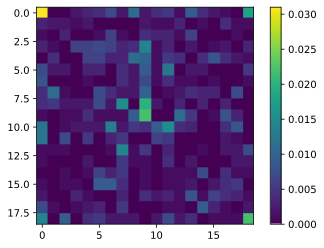

In [38]:
# adaclf is the trained adaboost classifier
adaclf = adacv.best_estimator_
fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly, we can also look at the important features for xgboost.

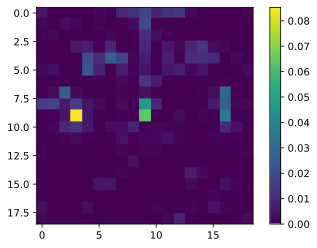

In [39]:
# xgbclf is the trained xgboost classifier
xgbclf = xgbcv.best_estimator_
fi = xgbclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

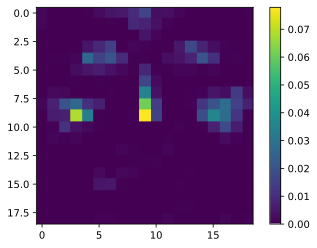

In [59]:
# rfclf is the trained random forest classifier
rfclf = rfrcv.best_estimator_
fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
1. The AdaBoost classifier: it puts more consideration on a top-left pixel and a bottom-right pixel(I do not know how to explain this phenomenon, it looks really strange). Then, it focuses on a small area around the nose tip. I also notice that the features are separated from each other.

2. The GradientBoost classifier: it focuses more on the left cheek, then the nose tip, followed by the right cheek and eyes area. The features used are not symmetric (but human faces are symmetric) so it might not be a good classifier.

3. The Random Forest classifier: it focuses symmetrically on eyes, cheeks, nose tip, and forehead. The nose tip attracts more attention. I think anyone can guess that this is a human face given this feature map.


For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 332


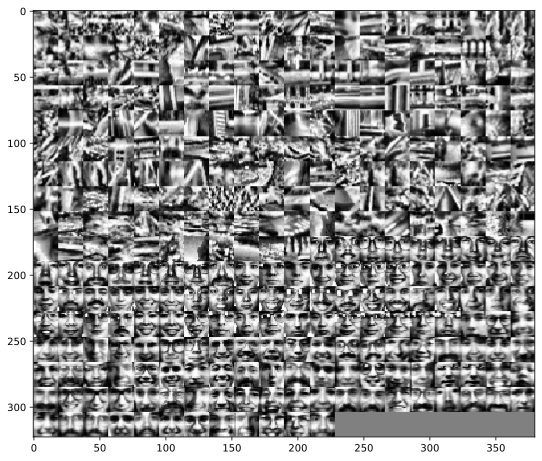

In [55]:
# svmclf is the trained SVM classifier
svmclf=svmpoly.best_estimator_

print("num support vectors:", len(svmclf.support_vectors_))
si  = svmclf.support_

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
1. First, I notice that there are more non-face support vectors on the decision margin, which suggests the classifier tend to classify face as non-face (the margin is closer to the non-face side). This observation also consists with the classifiaction report.

2. The classifier find hard (because those samples are tgreated as marginal sample on the decision boundary) about:

```
- The non-face samples with a vertical, diagonal or horizontal white line.
- The non-face samples which are symmetric.
- The non-face samples that look like human face with black color pixels around eyes and mouth area.

- The face samples that have glasses with light flection (white light reflection area).
- The face samples with grin (white tooth area).
- The face samples that have beard (black area).
```

Notes:
```
- '0': 11 + 20 * 9 = 191
- '1': 1 + 20 * 7 = 141
- Sum: 16 * 20 + 12 = 332
```

### Custom kernel SVM

Now we will try to use a custom kernel with the SVM.  We will consider the following RBF-like kernel based on L1 distance (i.e., cityblock or Manhattan distance),

$$ k(\mathbf{x},\mathbf{y}) = \exp \left(-\alpha \sum_{i=1}^d |x_i-y_i|\right)$$

where $x_i,y_i$ are the elements of the vectors $\mathbf{x},\mathbf{y}$, and $\alpha$ is the hyperparameter.  The difference with the RBF kernel is that the new kernel uses the absolute difference rather than the squared difference. **Thus, the new kernel does not "drop off" as fast as the RBF kernel using squared distance.**

- Implement the new kernel as a custom kernel function. The `scipy.spatial.distance.cdist` function will be helpful.
- Train the SVM with the new kernel.  To select the hyperparameter $\alpha$, you need to run cross-validation "manually" by: 1) trying different values of $\alpha$, and running cross-validation to select $C$; 2) selecting the  $\alpha$ with the highest cross-validation score `best_score_` in `GridSearchCV`.


## Example: Laplacian kernel
- $k(\mathbf{x}_1,\mathbf{x}_2) = \exp(-\alpha ||\mathbf{x}_1 - \mathbf{x}_2||)$

In [68]:
from scipy import spatial

def Manhattan_kernel(X1, X2, alpha=1.0):
    D = spatial.distance.cdist(X1, X2, metric = 'cityblock')
    return exp(-alpha*D)

In [94]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
paramgrid = {'C': np.array([0.1, 1.0, 10.0, 100.0])}

clf = {}
for i in alphas:
    tmpkern = lambda X1, X2, alpha=i: Manhattan_kernel(X1,X2,alpha = alpha)
    clf[i] = svm.SVC(kernel = tmpkern)
    
    svmmht = model_selection.GridSearchCV(clf[i], paramgrid,
                                          cv = 3, n_jobs = -1, verbose=True)
    svmmht.fit(trainX, trainY)
    
    print("alphas:", i)
    print("best params:", svmmht.best_params_)
    print("best score:", svmmht.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
alphas: 0.001
best params: {'C': 10.0}
best score: 0.9495921831656523
Fitting 3 folds for each of 4 candidates, totalling 12 fits
alphas: 0.01
best params: {'C': 10.0}
best score: 0.9576134681090588
Fitting 3 folds for each of 4 candidates, totalling 12 fits
alphas: 0.1
best params: {'C': 10.0}
best score: 0.66647936862817
Fitting 3 folds for each of 4 candidates, totalling 12 fits
alphas: 1.0
best params: {'C': 0.1}
best score: 0.6515763594387368
Fitting 3 folds for each of 4 candidates, totalling 12 fits
alphas: 10.0
best params: {'C': 0.1}
best score: 0.6515763594387368


In [95]:
tmpkern = lambda X1, X2, alpha=i: Manhattan_kernel(X1,X2,alpha = 0.01)

clf = svm.SVC(kernel = tmpkern, C = 10.0)
clf.fit(trainX, trainY)

predY = clf.predict(testX)
acc = metrics.accuracy_score(testY, predY)

print("SVM-Manhattan accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("Params: C = 10, alpha = 0.01")
print("------------------------------------------------------")

SVM-Manhattan accuracy = 0.6546610169491526
Classification Report
               precision    recall  f1-score   support

           0       0.59      1.00      0.74       472
           1       0.99      0.31      0.47       472

    accuracy                           0.65       944
   macro avg       0.79      0.65      0.61       944
weighted avg       0.79      0.65      0.61       944

Params: C = 10, alpha = 0.01
------------------------------------------------------


In [96]:
paramgrid = {'C': np.array([0.1, 1.0, 10.0, 100.0]),
             'gamma': np.array([0.1, 1.0, 10.0, 25.0])}

svmrbf = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid,
                                      cv=2, n_jobs=-1, verbose=True)
svmrbf.fit(trainX, trainY)

predY = svmrbf.best_estimator_.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("SVM-RBF accuracy =", acc)
print("Classification Report\n", classification_report(testY, predY))
print("Params: ", svmmht.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
SVM-RBF accuracy = 0.6514830508474576
Classification Report
               precision    recall  f1-score   support

           0       0.59      1.00      0.74       472
           1       0.99      0.31      0.47       472

    accuracy                           0.65       944
   macro avg       0.79      0.65      0.60       944
weighted avg       0.79      0.65      0.60       944

Params:  {'C': 0.1}


Does using the new kernel improve the results?
1. In my implementation, the Manhattan kernel SVM did not improve the classification result compared to the RBF kernel SVM.

2. The Manhattan kernel SVM used a larger C value C = 10 (more penalty for samples that violate the margin) while the RBF kernel SVM used a smaller C value C = 0.1 to achieve a similar result.

3. I think this is due to the way how Manhattan kernel SVM computes the kernel distance, the low speed "drop off" requires more penalty to converge.


## 3. Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [97]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

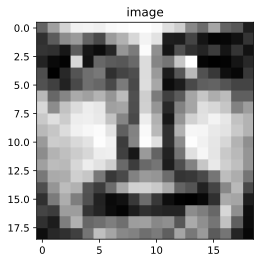

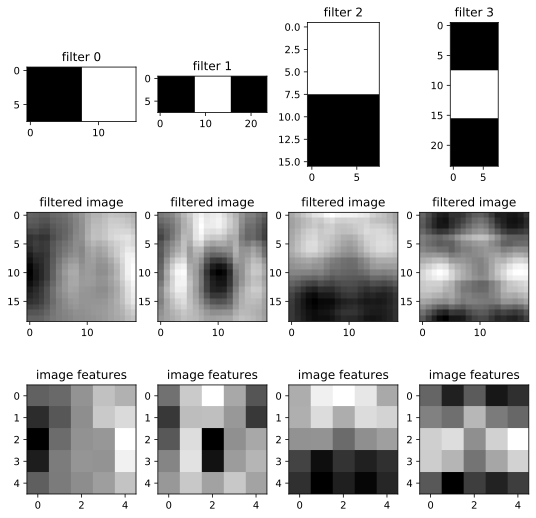

In [98]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [99]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

(1745, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [100]:
# first scale the features
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

### AdaBoost

In [104]:
paramgrid = {'learning_rate': np.array([1e-3,1e-2,1e-1,1]),
             'n_estimators': np.array([100, 500,1000])}

adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state = 0),
                                     paramgrid, cv = 3, n_jobs = -1)
adacv.fit(trainXfn, trainY)
print("best params:", adacv.best_params_)

predY_ada = adacv.best_estimator_.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_ada)
print("Ada test accuracy =", acc)

best params: {'learning_rate': 1.0, 'n_estimators': 500}
Ada test accuracy = 0.753177966101695


### SVM with RBF kernel

In [105]:
paramgrid = {'C': np.array([0.1, 1.0, 10.0, 100.0]),
             'gamma': np.array([0.1, 1.0, 10.0, 25.0])}

svmrbf = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid,
                                      cv = 3, n_jobs = -1, verbose=True)
svmrbf.fit(trainXfn, trainY)
print("best params:", svmrbf.best_params_)

predY_svmrbf = svmrbf.best_estimator_.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_svmrbf)
print("SVM-RBF Test accuracy =", acc)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best params: {'C': 10.0, 'gamma': 0.1}
SVM-RBF Test accuracy = 0.7595338983050848


### SVM with poly kernel

In [121]:
paramgrid = {'C': np.array([0.1, 1.0, 10.0, 100.0]),
             'gamma': np.array([0.1, 1.0, 10.0, 25.0])}

svmpoly = model_selection.GridSearchCV(svm.SVC(kernel='poly'), paramgrid,
                                      cv = 3, n_jobs = -1, verbose=True)
svmpoly.fit(trainXfn, trainY)
print("best params:", svmpoly.best_params_)

predY_svmpoly = svmpoly.best_estimator_.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_svmpoly)
print("SVM-Poly Test accuracy =", acc)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best params: {'C': 10.0, 'gamma': 0.1}
SVM-Poly Test accuracy = 0.809322033898305


### Random Forest Classifier

In [106]:
paramsampler = {'n_estimators':      np.array([10, 50, 100, 200]),
                'max_depth':         np.array([1, 4, 10, 20]),
                'min_samples_split': stats.uniform(0,0.5),
                'min_samples_leaf':  stats.uniform(0,0.5)}

rfrcv = model_selection.RandomizedSearchCV(
    nsemble.RandomForestClassifier(random_state=0, class_weight='balanced'),
    param_distributions=paramsampler, random_state=0,
    n_iter = 200, cv = 3, verbose = 1, n_jobs = -1)

rfrcv.fit(trainXfn, trainY);
print("best params:", rfrcv.best_params_)

predY_rf = rfrcv.best_estimator_.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_rf)
print("Random Forest Classifier Test accuracy =", acc)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
best params: {'max_depth': 20, 'min_samples_leaf': 0.027982914174723927, 'min_samples_split': 0.04326624509969401, 'n_estimators': 100}
Random Forest Classifier Test accuracy = 0.8146186440677966


### Error Analysis
Repeat the error analysis for the new classifiers.

In [112]:
# predY is the prediction from SVM-Poly classifier
predY_svm = predY_svmpoly

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY_svm[Pind])
FP = count_nonzero(testY[Pind] != predY_svm[Pind])
TN = count_nonzero(testY[Nind] == predY_svm[Nind])
FN = count_nonzero(testY[Nind] != predY_svm[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
Accuracy = (TP + TN) / (TP + FP + FN + TN)

print("TP = ", TP)
print("FP = ", FP)
print("TN = ", TN)
print("FN = ", FN)
print("TPR = ", TPR)
print("FPR = ", FPR)
print("Accuracy =", Accuracy)

TP =  303
FP =  169
TN =  461
FN =  11
TPR =  0.964968152866242
FPR =  0.26825396825396824
Accuracy = 0.809322033898305


How has the classifier using image features improved?

1. High TP and Low FP. The TPR is increased while the FPR is decreased. These two metrics all imply the classifier's performance is improved: i.e., more faces are correctly classified to faces while fewer non-faces are classified to faces.

2. The accuracy is much improved from 0.6+ to around 0.8.

3. After the feature extraction, we successfully reduce FN, i.e., we encourage the classifier to classify more face samples as a face rather than non-face. But the FP are increased at the same time. 

Notes (the classifier's performance before extraction):
```
TP =  158
FP =  1
TN =  471
FN =  314
TPR =  0.3347457627118644
FPR =  0.00211864406779661
Accuracy = 0.6663135593220338
```

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [116]:
fname = "nasa-small.png"

(210, 480)


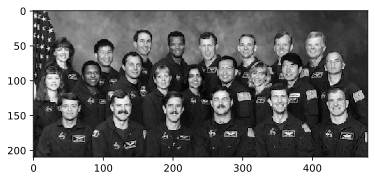

In [117]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [118]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


Now predict using your classifier.  The extracted features are in `newXf`, and scaled features are `newXfn`.

In [119]:
newXfn  = scalerf.transform(newXf)        # apply scaling to test data

In [128]:
### INSERT YOUR CODE HERE
# prednewY = svmpoly.best_estimator_.predict(newXfn)
prednewY = rfrcv.best_estimator_.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

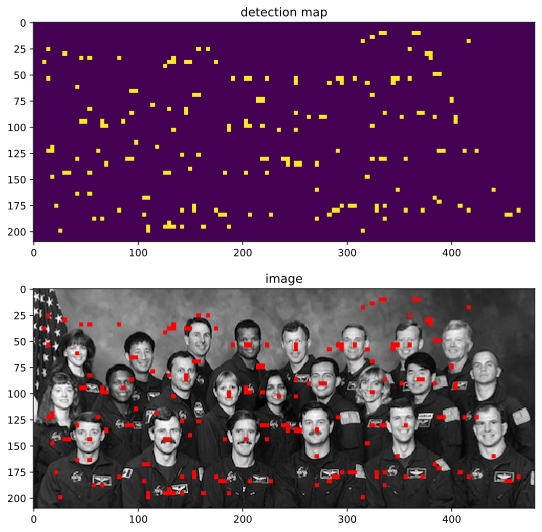

In [129]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_

1. It detects most of the faces in the image (red dots recognize the nose tip).
2. It has a high false-positive rate (recognize non-face pixels as face pixels).
3. It seems that our classifier has a special preference to recognize the chest cards as faces, I guess that is mainly due to these areas have black and white pixel appear alternately.
4. If we limit the classifier's behavior (only out high-probability area), maybe we can do better.

You can try it on your own images.  The faces should all be around 19x19 pixels though.
We only used 1/4 of the training data. Try using more data to train it!